## Set up Environment by enabling the current workspace venv

In [1]:
!pip freeze

appnope==0.1.4
asttokens==3.0.0
comm==0.2.2
contourpy==1.3.1
cycler==0.12.1
debugpy==1.8.13
decorator==5.2.1
executing==2.2.0
fonttools==4.56.0
imageio==2.37.0
ipykernel==6.29.5
ipython==9.0.1
ipython_pygments_lexers==1.1.1
jedi==0.19.2
jupyter_client==8.6.3
jupyter_core==5.7.2
kiwisolver==1.4.8
matplotlib==3.10.1
matplotlib-inline==0.1.7
nest-asyncio==1.6.0
numpy==2.2.3
packaging==24.2
pandas==2.2.3
parso==0.8.4
pexpect==4.9.0
pillow==11.1.0
platformdirs==4.3.6
prompt_toolkit==3.0.50
psutil==7.0.0
ptyprocess==0.7.0
pure_eval==0.2.3
Pygments==2.19.1
pyparsing==3.2.1
python-dateutil==2.9.0.post0
pytz==2025.1
pyzmq==26.2.1
scipy==1.15.2
six==1.17.0
stack-data==0.6.3
tornado==6.4.2
tqdm==4.67.1
traitlets==5.14.3
tzdata==2025.1
wcwidth==0.2.13


In [2]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install tqdm
!pip install scipy
!pip install imageio

## Initialize some values
Here is how we are going to set this up, the entire map will be from {0<=x<=1} {0<=y<=1} 
The heuristic map will be split using the mapResolution variable to then split this 1x1 grid into sections to then generate an approximated heuristic

In [26]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from tqdm import tqdm
import time

# Function to normalize heuristic map (0-1) then convert to probability distribution
def normalize_to_probability(heuristic_map):
    # Step 1: Linear Normalization (0 to 1)
    min_val, max_val = np.min(heuristic_map), np.max(heuristic_map)
    linear_norm = (heuristic_map - min_val) / (max_val - min_val)  # Scale to [0,1]

    # Step 2: Normalize so it sums to 1 (Probability Distribution)
    return linear_norm / np.sum(linear_norm)

# Function to pick a weighted random cell
def pick_weighted_random_cell(heuristic_map):
    # Normalize and convert to probability distribution in one step
    normalized_map = normalize_to_probability(heuristic_map)
    
    # Flatten for random selection
    flat_map = normalized_map.flatten()
    
    # Pick a random cell based on probability
    index = np.random.choice(len(flat_map), p=flat_map)
    return np.unravel_index(index, heuristic_map.shape)  # Convert back to 2D index

# Euclidean distance heuristic function
def euclidean_distance_heuristic(x, y, goal):
    return np.sqrt(2) - np.sqrt((x - goal[0])**2 + (y - goal[1])**2)

def pick_pure_random_point():
    return (np.random.uniform(0, 1), np.random.uniform(0, 1))

# Function to check if a line segment intersects any obstacle
def is_legal_move(start, end, obstacles):
    x1, y1 = start
    x2, y2 = end
    
    # Check if the move is within the bounds of the 1x1 map
    if not (0 <= x1 <= 1 and 0 <= y1 <= 1 and 0 <= x2 <= 1 and 0 <= y2 <= 1):
        return False
    
    for (x_min, y_min), (x_max, y_max) in obstacles:
        # Check if either endpoint is inside the obstacle (edge case)
        if (x_min <= x1 <= x_max and y_min <= y1 <= y_max) or (x_min <= x2 <= x_max and y_min <= y2 <= y_max):
            return False
        
        # Check for intersection with the four edges of the rectangle
        edges = [
            ((x_min, y_min), (x_max, y_min)),
            ((x_max, y_min), (x_max, y_max)),
            ((x_max, y_max), (x_min, y_max)),
            ((x_min, y_max), (x_min, y_min))
        ]
        
        for (ex1, ey1), (ex2, ey2) in edges:
            if line_intersects((x1, y1), (x2, y2), (ex1, ey1), (ex2, ey2)):
                return False
    return True

# Function to check if two line segments intersect
def line_intersects(A, B, C, D):
    def ccw(P, Q, R):
        return (R[1] - P[1]) * (Q[0] - P[0]) > (Q[1] - P[1]) * (R[0] - P[0])
    return ccw(A, C, D) != ccw(B, C, D) and ccw(A, B, C) != ccw(A, B, D)

# WRRT Algorithm
def wrrt_algorithm(start, goal, goalRange, heuristicMap, distanceUnit, heuristic2coord, pick_random_cell, obstacles):
    tree = {start: (None, 0)}  # Dictionary to store parent and generation for each node
    path = [start]

    while np.linalg.norm(np.array(path[-1]) - np.array(goal)) > goalRange:
        new_point = heuristic2coord(*pick_random_cell(heuristicMap))
        
        # Find the closest node in the path to the new point
        closest_node = min(path, key=lambda node: np.linalg.norm(np.array(new_point) - np.array(node)))
        
        # Calculate the new point that is distanceUnit away from the closest node
        direction = np.array(new_point) - np.array(closest_node)
        direction = direction / np.linalg.norm(direction)
        new_point = tuple(np.array(closest_node) + direction * distanceUnit)
        
        # Ensure the movement is legal
        if is_legal_move(closest_node, new_point, obstacles):
            path.append(new_point)
            tree[new_point] = (closest_node, tree[closest_node][1] + 1)
    
    return tree, tree[path[-1]][1]

# RRT Algorithm
def rrt_algorithm(start, goal, goalRange, distanceUnit, pick_random_point, obstacles):
    tree = {start: (None, 0)}  # Dictionary to store parent and generation for each node
    path = [start]

    while np.linalg.norm(np.array(path[-1]) - np.array(goal)) > goalRange:
        new_point = pick_random_point()
        
        # Find the closest node in the path to the new point
        closest_node = min(path, key=lambda node: np.linalg.norm(np.array(new_point) - np.array(node)))
        
        # Calculate the new point that is distanceUnit away from the closest node
        direction = np.array(new_point) - np.array(closest_node)
        direction = direction / np.linalg.norm(direction)
        new_point = tuple(np.array(closest_node) + direction * distanceUnit)
        
        # Ensure the movement is legal
        if is_legal_move(closest_node, new_point, obstacles):
            path.append(new_point)
            tree[new_point] = (closest_node, tree[closest_node][1] + 1)
    
    return tree, tree[path[-1]][1]


# Function to solve the problem
def solve(algorithm_choice, start, goal, mapResolution, goalRange, distanceUnit, obstacles, iterations=1):
    results = []
    
    print(f"Running the {algorithm_choice.__name__}: {iterations} iterations...")
    for _ in tqdm(range(iterations)):
        if algorithm_choice == rrt_algorithm:
            start_time = time.time()
            solved = algorithm_choice(start, goal, goalRange, distanceUnit, pick_pure_random_point, obstacles)
            end_time = time.time()
        else:
            # Initialize heuristic map
            # print("Generating heuristic map...")
            heuristicMap = np.zeros((mapResolution, mapResolution))
            for i in range(mapResolution):
                for j in range(mapResolution):
                    heuristicMap[i, j] = euclidean_distance_heuristic(i/mapResolution, j/mapResolution, goal)

            # Run the WRRT algorithm and record the time taken
            start_time = time.time()
            solved = algorithm_choice(start, goal, goalRange, heuristicMap, distanceUnit, lambda x, y: (np.random.uniform(x/mapResolution, (x+1)/mapResolution), np.random.uniform(y/mapResolution, (y+1)/mapResolution)), pick_weighted_random_cell, obstacles)
            end_time = time.time()

        # Append the result of the current iteration to the results list
        temp_results={
            "tree": solved[0],
            "path_length": solved[1],
            "time": end_time - start_time
        }
        results.append(temp_results)
    
    # Return the list of results
    return results
    

Running the wrrt_algorithm: 1 iterations...


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

Average time taken: 0.44 seconds
Average generation count: 52.00 generations


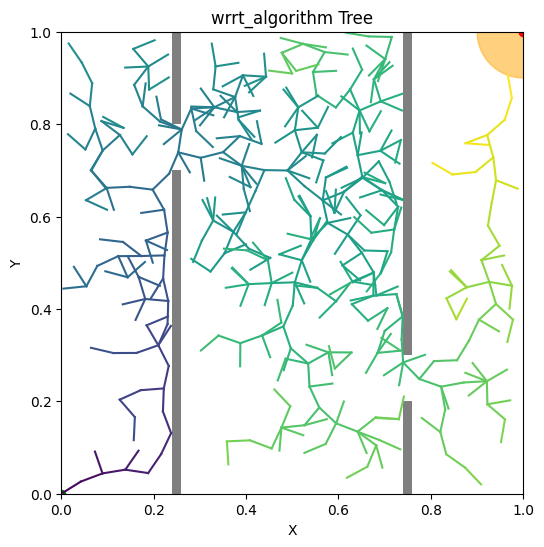

Running the rrt_algorithm: 1 iterations...


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Average time taken: 1.86 seconds
Average generation count: 62.00 generations


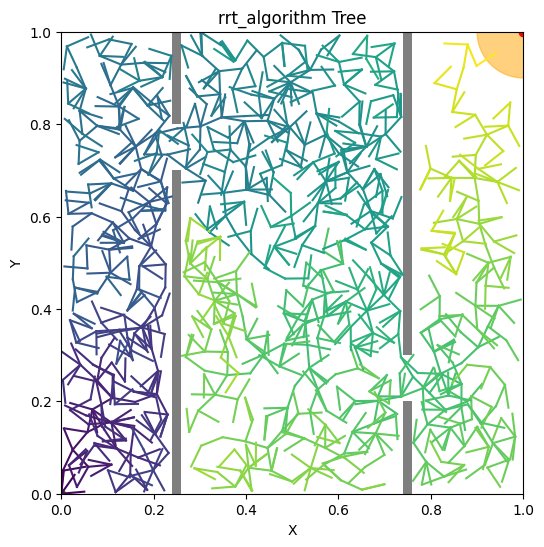

In [40]:
# Define parameters
start = (0, 0)
goal = (1, 1)
mapResolution = 16
goalRange = 0.1
distanceUnit = 0.05
obstacles = [((0.24, 0), (0.26, 0.7)), ((0.24, 0.8), (0.26, 1)), ((0.74, 0), (0.76, 0.2)), ((0.74, 0.3), (0.76, 1))]
algorithm_choice = wrrt_algorithm
iterations = 1

# Solve the problem
solved_data = solve(algorithm_choice ,start, goal, mapResolution, goalRange, distanceUnit, obstacles, iterations=iterations)

# print some average statistics
average_time = np.mean([data["time"] for data in solved_data])
average_generation = np.mean([data["path_length"] for data in solved_data])
print(f"Average time taken: {average_time:.2f} seconds")
print(f"Average generation count: {average_generation:.2f} generations")

# Plot the results
for solved in solved_data:
    tree = solved["tree"]
    plt.figure(figsize=(6, 6))
    plt.plot(start[0], start[1], 'go', label='Start')  # green dot for start
    # orange filled circle for goal range
    plt.gca().add_patch(plt.Circle(goal, goalRange, color='orange', alpha=0.5))
    plt.plot(goal[0], goal[1], 'ro', label='Goal')    # red dot for goal
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('X')
    plt.ylabel('Y')

    # plot obstacles
    for (x_min, y_min), (x_max, y_max) in obstacles:
        plt.fill([x_min, x_max, x_max, x_min], [y_min, y_min, y_max, y_max], 'k', alpha=0.5)
    

    for node, (parent, generation) in tree.items():
        if parent is not None:
            # color code based on generation
            color = plt.cm.viridis(generation / max(tree.values(), key=lambda x: x[1])[1])
            plt.plot([parent[0], node[0]], [parent[1], node[1]], color=color)

    plt.title(f'{algorithm_choice.__name__} Tree')
    plt.show()
    break

algorithm_choice=rrt_algorithm

solved_data = solve(algorithm_choice ,start, goal, mapResolution, goalRange, distanceUnit, obstacles, iterations=iterations)

# print some average statistics
average_time = np.mean([data["time"] for data in solved_data])
average_generation = np.mean([data["path_length"] for data in solved_data])
print(f"Average time taken: {average_time:.2f} seconds")
print(f"Average generation count: {average_generation:.2f} generations")

# Plot the results
for solved in solved_data:
    tree = solved["tree"]
    plt.figure(figsize=(6, 6))
    plt.plot(start[0], start[1], 'go', label='Start')  # green dot for start
    # orange filled circle for goal range
    plt.gca().add_patch(plt.Circle(goal, goalRange, color='orange', alpha=0.5))
    plt.plot(goal[0], goal[1], 'ro', label='Goal')    # red dot for goal
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('X')
    plt.ylabel('Y')

    # plot obstacles
    for (x_min, y_min), (x_max, y_max) in obstacles:
        plt.fill([x_min, x_max, x_max, x_min], [y_min, y_min, y_max, y_max], 'k', alpha=0.5)
    

    for node, (parent, generation) in tree.items():
        if parent is not None:
            # color code based on generation
            color = plt.cm.viridis(generation / max(tree.values(), key=lambda x: x[1])[1])
            plt.plot([parent[0], node[0]], [parent[1], node[1]], color=color)

    plt.title(f'{algorithm_choice.__name__} Tree')
    plt.show()
    break


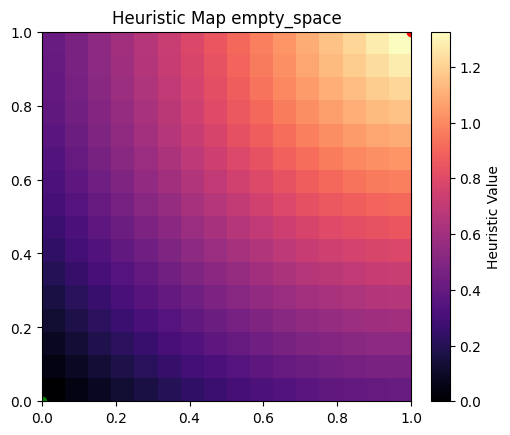

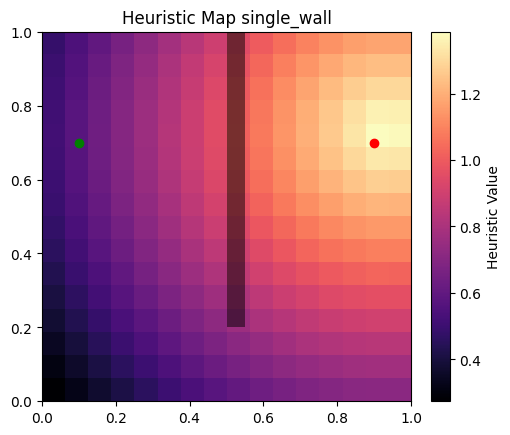

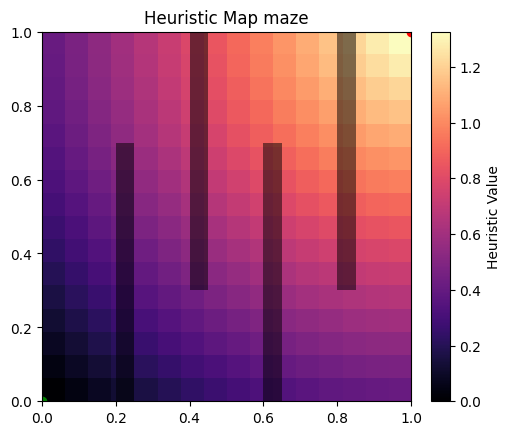

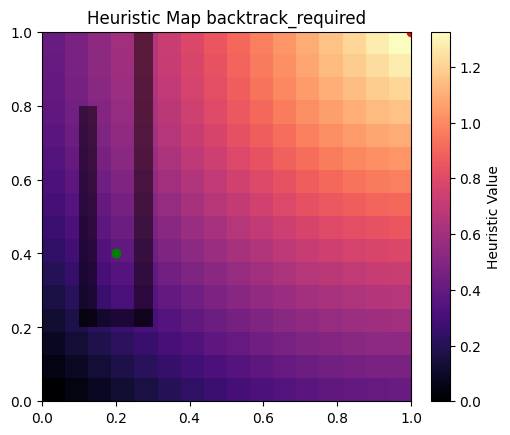

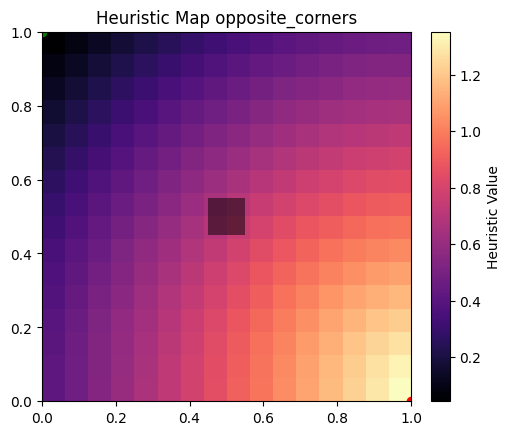

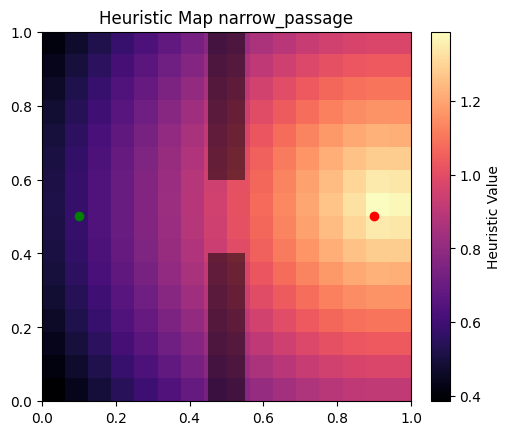

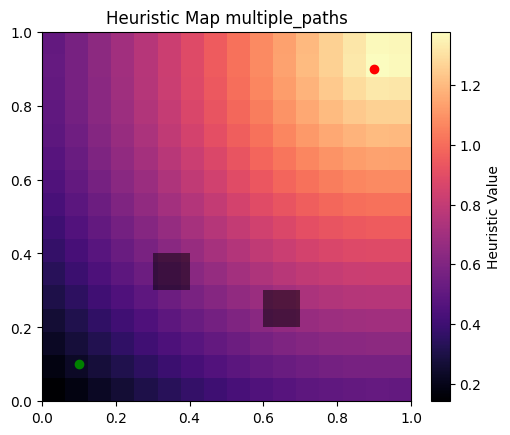

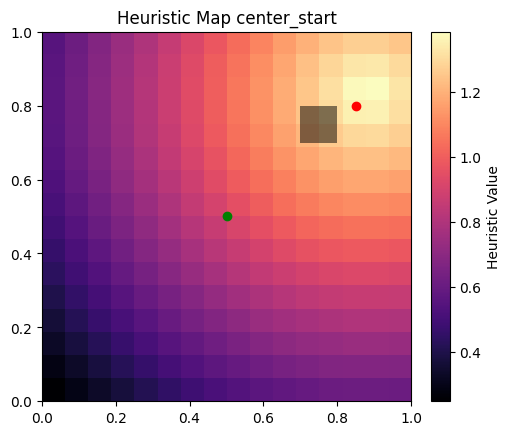

In [ ]:
# load the scenarios.json
import json
with open('scenarios.json') as f:
    scenarios = json.load(f)

for scenario in scenarios.keys():
    name=scenario
    scenario = scenarios[scenario]
    start = scenario['start']
    goal = scenario['goal']
    mapResolution = scenario['mapResolution']
    goalRange = scenario['goalRange']
    distanceUnit = scenario['distanceUnit']
    obstacles = scenario['obstacles']
    # generate the heuristic map for scenario then show it
    heuristicMap = np.zeros((scenario['mapResolution'], scenario['mapResolution']))

    for i in range(scenario['mapResolution']):
        for j in range(scenario['mapResolution']):
            heuristicMap[i, j] = euclidean_distance_heuristic(j/scenario['mapResolution'], i/scenario['mapResolution'], scenario['goal'])

    # Normalize map to probability distribution
    normalized_map = normalize_to_probability(heuristicMap)
    # overlay heuristic map
    plt.imshow(heuristicMap, cmap='magma', interpolation='nearest', extent=[0, 1, 0, 1], origin='lower')

    # plot obstacles
    for (x_min, y_min), (x_max, y_max) in scenario['obstacles']:
        #Plt with hatched lines of same color thick lines with no background color or outline full white
        plt.fill([x_min, x_max, x_max, x_min], [y_min, y_min, y_max, y_max], 'k', alpha=0.5)

    # plot start and goal
    plt.plot(start[0], start[1], 'go', label='Start')  # green dot for start
    plt.plot(goal[0], goal[1], 'ro', label='Goal')    # red dot for goal

    plt.colorbar(label='Heuristic Value', fraction=0.046, pad=0.04)
    plt.title(f'Heuristic Map {name}')
    plt.show()

Running the wrrt_algorithm: 2 iterations...


100%|██████████| 2/2 [00:00<00:00, 12.65it/s]

Average time taken: 0.08 seconds
Average generation count: 32.50 generations


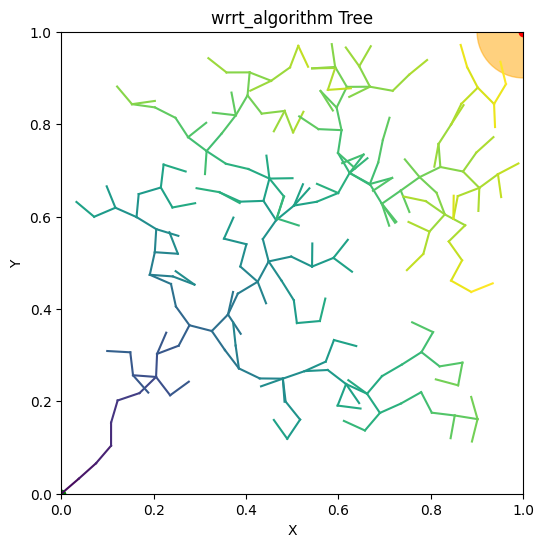

Running the wrrt_algorithm: 2 iterations...


100%|██████████| 2/2 [00:00<00:00, 20.07it/s]


Average time taken: 0.05 seconds
Average generation count: 33.00 generations


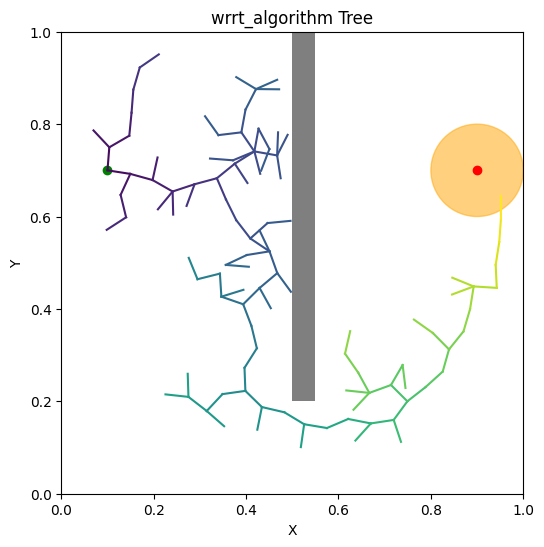

Running the wrrt_algorithm: 2 iterations...


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]

Average time taken: 1.00 seconds
Average generation count: 80.00 generations


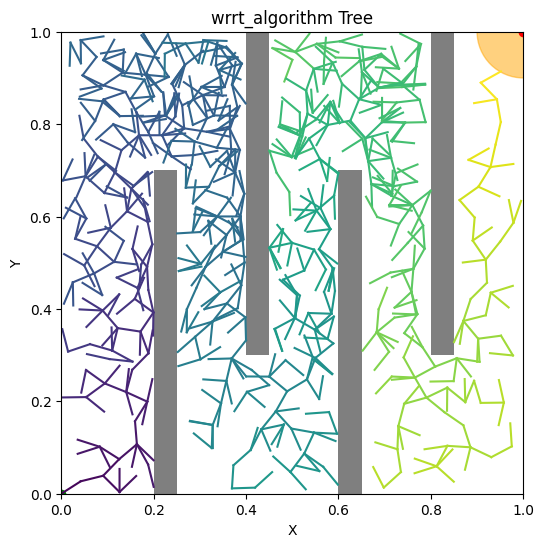

Running the wrrt_algorithm: 2 iterations...


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]

Average time taken: 1.54 seconds
Average generation count: 60.50 generations


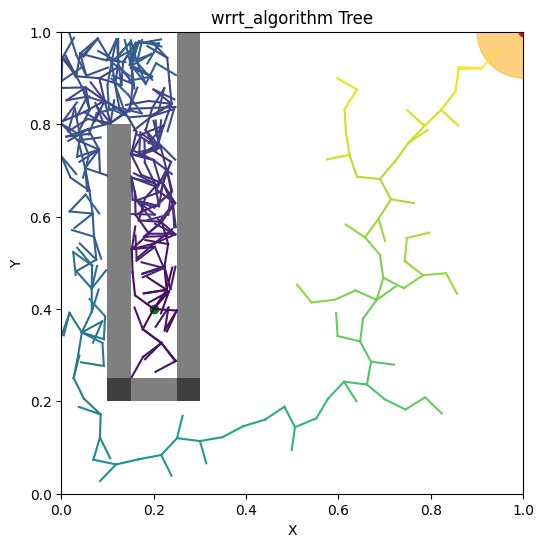

Running the wrrt_algorithm: 2 iterations...


100%|██████████| 2/2 [00:00<00:00, 23.30it/s]

Average time taken: 0.04 seconds
Average generation count: 32.50 generations


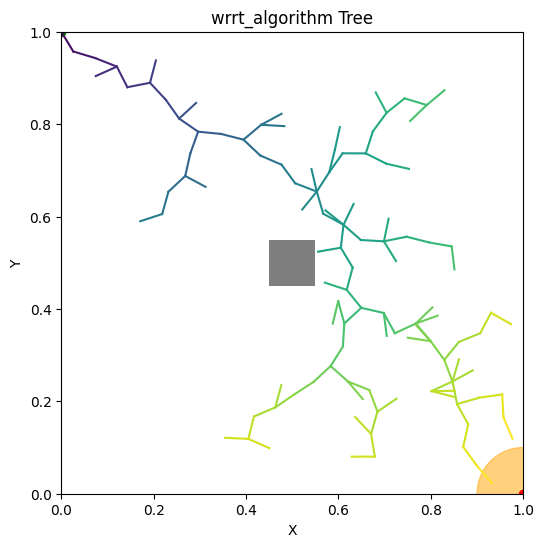

Running the wrrt_algorithm: 2 iterations...


100%|██████████| 2/2 [00:00<00:00, 28.08it/s]

Average time taken: 0.03 seconds
Average generation count: 18.00 generations


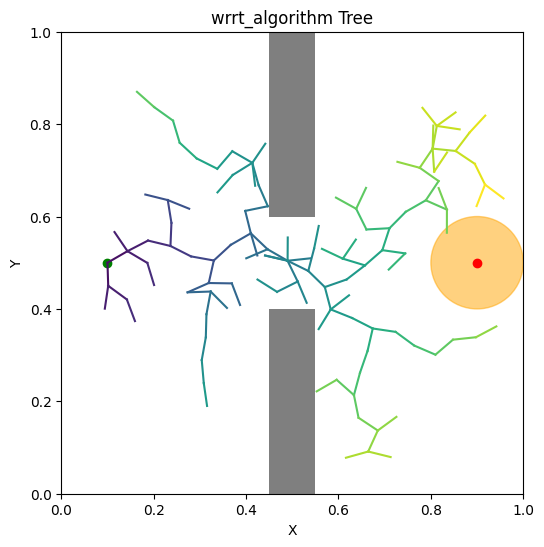

Running the wrrt_algorithm: 2 iterations...


100%|██████████| 2/2 [00:00<00:00, 109.52it/s]


Average time taken: 0.01 seconds
Average generation count: 25.50 generations


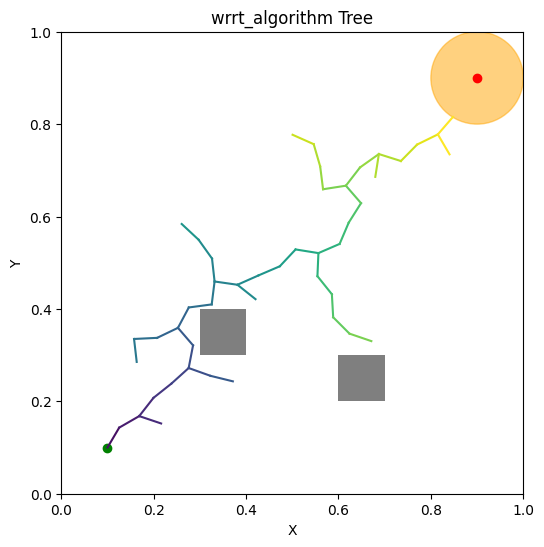

Running the wrrt_algorithm: 2 iterations...


100%|██████████| 2/2 [00:00<00:00, 80.58it/s]


Average time taken: 0.01 seconds
Average generation count: 11.50 generations


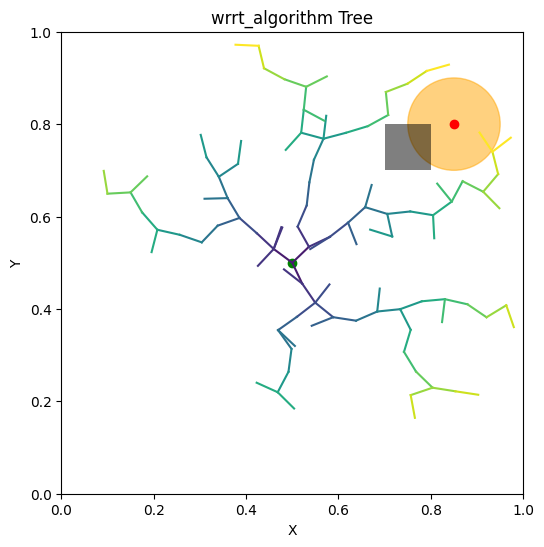

In [38]:
for scenario in scenarios.keys():
# Convert start and goal to tuples
    start = tuple(scenarios[scenario]['start'])
    goal = tuple(scenarios[scenario]['goal'])
    mapResolution = scenarios[scenario]['mapResolution']
    goalRange = scenarios[scenario]['goalRange']
    distanceUnit = scenarios[scenario]['distanceUnit']
    obstacles = scenarios[scenario]['obstacles']
    

    # Run the WRRT algorithm
    algorithm_choice = wrrt_algorithm
    iterations = 2
    solved_data = solve(algorithm_choice, start, goal, mapResolution, goalRange, distanceUnit, obstacles, iterations=iterations)

    # Print some average statistics
    average_time = np.mean([data["time"] for data in solved_data])
    average_generation = np.mean([data["path_length"] for data in solved_data])
    print(f"Average time taken: {average_time:.2f} seconds")
    print(f"Average generation count: {average_generation:.2f} generations")

    # Plot the results
    for solved in solved_data:
        tree = solved["tree"]
        plt.figure(figsize=(6, 6))
        plt.plot(start[0], start[1], 'go', label='Start')  # green dot for start
        # orange filled circle for goal range
        plt.gca().add_patch(plt.Circle(goal, goalRange, color='orange', alpha=0.5))
        plt.plot(goal[0], goal[1], 'ro', label='Goal')    # red dot for goal
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlabel('X')
        plt.ylabel('Y')

        # plot obstacles
        for (x_min, y_min), (x_max, y_max) in obstacles:
            plt.fill([x_min, x_max, x_max, x_min], [y_min, y_min, y_max, y_max], 'k', alpha=0.5)
        

        for node, (parent, generation) in tree.items():
            if parent is not None:
                # color code based on generation
                color = plt.cm.viridis(generation / max(tree.values(), key=lambda x: x[1])[1])
                plt.plot([parent[0], node[0]], [parent[1], node[1]], color=color)

        plt.title(f'{algorithm_choice.__name__} Tree')
        plt.show()
        break
